In [1]:
### Packages and Dependencies
!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install polytope

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected pac

In [2]:
import numpy as np
import math

### Trajectory Generation Reordering
def reorder(traj, N, time):
  ref = []
  length = len(traj)
  for i in range(N):
    if time+i < length:
      ref.append(traj[time+i])
    else:
      j = 0
      temp = time+i
      while temp - (j+1)*length >= 0:
        j += 1
      ref.append(traj[(time+i)-j*length])
  return np.array(ref)

def reorder_theta(traj, N, time):
  ref = []
  length = len(traj)
  for i in range(N):
    if time+i < length:
      ref.append(traj[time+i])
    else:
      j = 0
      temp = time+i
      while temp - (j+1)*length >= 0:
        j += 1
      if(traj[length-1]) > 0:
        ref.append(traj[(time+i)-j*length]+j*2*np.pi)
      else:
        ref.append(traj[(time+i)-j*length]-j*2*np.pi)
  return np.array(ref)

In [3]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import scipy.signal
import scipy.linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import polytope as pt
from pyomo.environ import sin, cos, tan, asin, acos, atan

# Constants
l_r = 0.160 #distance from the center of the mass of the vehicle to the rear axle [m]
l_f = 0.164 #distance from the center of the mass of the vehicle to the front axle [m]
car_length = l_r+l_f

def solve_cftoc(N, x0, xL, xU, uL, uU, xref, yref, thetaref, Ts, nx, nu, dynamicsModel):
    model = pyo.ConcreteModel()
    model.N = N
    model.nx = nx
    model.nu = nu

    # length of finite optimization problem:
    model.tIDX = pyo.Set( initialize= range(0,model.N+1), ordered=True )
    model.xIDX = pyo.Set( initialize= range(0,model.nx), ordered=True )
    model.uIDX = pyo.Set( initialize= range(0,model.nu), ordered=True )

    # Create state and input variables trajectory:
    model.x = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.uIDX, model.tIDX)

    #Objective:
    if dynamicsModel == 'unicycle':
      def objective_rule(model):
          costX = 0.0
          costU = 0.0
          # Unicycle model
          for t in model.tIDX:
            if t < model.N:
              costX += (model.x[0, t]-xref[t]) * 1 * (model.x[0, t]-xref[t])   ### Tracking x and y only
              costX += (model.x[1, t]-yref[t]) * 1 * (model.x[1, t]-yref[t])
              costX += (model.x[2, t]-thetaref[t]) * 0.5 * (model.x[2, t]-thetaref[t])
            elif t == model.N:
              costX += (model.x[0, N]-xref[N]) * 5 * (model.x[0, N]-xref[N])
              costX += (model.x[1, N]-yref[N]) * 5 * (model.x[1, N]-yref[N])
              costX += (model.x[2, t]-thetaref[t]) * 0.5 * (model.x[2, t]-thetaref[t])
          return costX
    elif dynamicsModel == 'kinBicycle':
      def objective_rule(model):
          costX = 0.0
          costU = 0.0
          # Dynamic Bicycle model
          for t in model.tIDX:
            if t < model.N:
              costX += (model.x[0, t]-xref[t]) * 2 * (model.x[0, t]-xref[t])   ### Tracking x and y only
              costX += (model.x[1, t]-yref[t]) * 2 * (model.x[1, t]-yref[t])
              costX += (model.x[2, t]+model.x[4, t]-thetaref[t]) * 0.5 * (model.x[2, t]+model.x[4, t]-thetaref[t])
            elif t == model.N:
              costX += (model.x[0, N]-xref[N]) * 20 * (model.x[0, N]-xref[N])
              costX += (model.x[1, N]-yref[N]) * 20 * (model.x[1, N]-yref[N])
              costX += (model.x[2, t]+model.x[4, t]-thetaref[t]) * 5 * (model.x[2, t]+model.x[4, t]-thetaref[t])
          return costX
    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    # Constraints:
    # Initial condition
    model.constraint1 = pyo.Constraint(model.xIDX, rule=lambda model, i: model.x[i, 0] == x0[i])

    if dynamicsModel == 'unicycle':
      # Unicycle model
      # State and Input Limits
      model.constraint2 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.x[3, t] <= xU[3]))
      model.constraint3 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.x[3, t] >= xL[3]))

      model.constraint4 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.u[0, t] <= uU[0]))
      model.constraint5 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.u[0, t] >= uL[0]))

      # State dynamics
      model.constraint6 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0,t+1] == model.x[0,t] + Ts*model.u[0,t]*pyo.cos(model.x[2,t]) if t < model.N else pyo.Constraint.Skip)
      model.constraint7 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1,t+1] == model.x[1,t] + Ts*model.u[0,t]*pyo.sin(model.x[2,t]) if t < model.N else pyo.Constraint.Skip)
      model.constraint8 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[2,t+1] == model.x[2,t] + Ts*(1/car_length)*model.u[0,t]*pyo.tan(model.x[3,t]) if t < model.N else pyo.Constraint.Skip)
      model.constraint9 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[3,t+1] == model.x[3,t] + Ts*model.u[1,t] if t < model.N else pyo.Constraint.Skip)
    elif dynamicsModel == 'kinBicycle':
      # Dynamic Bicycle Model
      # State and Input Limits
      model.constraint2 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.x[3, t] <= xU[3]))
      model.constraint3 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.x[3, t] >= xL[3]))

      model.constraint4 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.u[0, t] <= uU[0]))
      model.constraint5 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.u[0, t] >= uL[0]))
      model.constraint6 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.u[1, t] <= uU[1]))
      model.constraint7 = pyo.Constraint(model.tIDX, rule=lambda model, t: (model.u[1, t] >= uL[1]))

      # State dynamics
      model.constraint8 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[0,t+1] == model.x[0,t] + Ts*model.x[3,t]*pyo.cos(model.x[2,t]+model.x[4,t]) if t < model.N else pyo.Constraint.Skip)
      model.constraint9 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[1,t+1] == model.x[1,t] + Ts*model.x[3,t]*pyo.sin(model.x[2,t]+model.x[4,t]) if t < model.N else pyo.Constraint.Skip)
      model.constraint10 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[2,t+1] == model.x[2,t] + Ts*(model.x[3,t]/car_length)*pyo.sin(model.x[4,t]) if t < model.N else pyo.Constraint.Skip)
      model.constraint11 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[3,t+1] == model.x[3,t] + Ts*model.u[0,t] if t < model.N else pyo.Constraint.Skip)
      model.constraint12 = pyo.Constraint(model.tIDX, rule=lambda model, t: model.x[4,t+1] == model.x[4,t] + Ts*pyo.atan((l_r/car_length)*pyo.tan(model.u[1,t])) if t < model.N else pyo.Constraint.Skip)

    solver = pyo.SolverFactory('ipopt')
    # solver.options['tol'] = 1e-6
    # solver.options['max_iter'] = 50000
    results = solver.solve(model)

    if str(results.solver.termination_condition) == "optimal":
        feas = True
    else:
        feas = False
        print(feas)

    xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T

    JOpt = model.cost()
    return [feas, xOpt, uOpt, JOpt]

In [14]:
import pandas as pd
import math

# Extracting x and y
def genWaypoints(raceTrack):
  if raceTrack == 'IMS':
    # First map (IMS)
    raceline_pts = pd.read_csv('ME292B_FinalProject/f1tenth_racetracks/IMS/IMS_raceline_1.csv',sep=';')
    raceline_x = np.array(raceline_pts[' x_m'])
    raceline_y = np.array(raceline_pts[' y_m'])
    raceline_theta = np.array(raceline_pts[' psi_rad'])
    for i in range(len(raceline_theta)):
      if i >= 286:
        raceline_theta[i] = raceline_theta[i]+2*np.pi

  elif raceTrack == 'BrandsHatch':
    ## For second map (BrandsHatch)
    raceline_pts = pd.read_csv('ME292B_FinalProject/f1tenth_racetracks/BrandsHatch/BrandsHatch_raceline_mod.csv',sep=';')
    raceline_x = np.array(raceline_pts[' x_m'])
    raceline_y = np.array(raceline_pts[' y_m'])
    raceline_theta = np.array(raceline_pts[' psi_rad'])
    for i in range(len(raceline_theta)):
      if i >= 83:
        raceline_theta[i] -= 2*np.pi

  elif raceTrack == 'Example':
    ## For third map (example)
    raceline_pts = pd.read_csv('ME292B_FinalProject/f1tenth_racetracks/example/example_waypoints_1.csv',sep=';')
    raceline_x = np.array(raceline_pts[' x_m'])
    raceline_y = np.array(raceline_pts[' y_m'])
    raceline_theta = np.array(raceline_pts[' psi_rad'])
    raceline_x = raceline_x[:-1]
    raceline_y = raceline_y[:-1]
    raceline_theta = raceline_theta[:-1]
    for i in range(len(raceline_theta)):
        raceline_theta[i] += np.pi/2
        if i >= 307 and i <=351:
          raceline_theta[i] += 2*np.pi
        if i >= 426:
          raceline_theta[i] += 2*np.pi
  return raceline_x, raceline_y, raceline_theta

In [5]:
def main(raceTrack, dynamicsModel):
  raceline_x, raceline_y, raceline_theta = genWaypoints(raceTrack)
  if dynamicsModel == "unicycle":
    # Unicycle Model
    # Limits on state variables
    v_min = 0  #minimum x velocity [m/s]
    v_max = 20  #minimum x velocity [m/s]

    s_min = -0.42
    s_max = 0.42

    xL = np.array([0, 0, 0, s_min]) # 4 by 1
    xU = np.array([0, 0, 0, s_max]) # 4 by 1

    # Limits on input variables
    uL = np.array([v_min, -3]) # 1 by 1
    uU = np.array([v_max, 3]) # 1 by 1

    # Initial conditions
    x0 = np.array([raceline_x[0], raceline_y[0], raceline_theta[0], 0])

    nx = 4
    nu = 2

    # Initial conditions
    x0 = np.array([raceline_x[0], raceline_y[0], raceline_theta[0], 0])

    N = 30

  elif dynamicsModel == "kinBicycle":
    # Dynamic Bicycle Model
    # Limits on state variables
    v_min = 0  #minimum velocity [m/s]
    v_max = 20  #minimum velocity [m/s]

    a_min = -9.5  #minimum acceleration [m/s]
    a_max = 9.5  #minimum acceleration [m/s]

    s_min = -0.42
    s_max = 0.42

    # States: x,y,inertial heading,velcoity, Beta(angle of current velocity of com wrt longitudinal axis of car)
    xL = np.array([0, 0, 0, v_min, 0]) # 4 by 1
    xU = np.array([0, 0, 0, v_max, 0]) # 4 by 1

    # Limits on input variables
    # States: acceleration, front steering angle
    uL = np.array([a_min, s_min]) # 1 by 1
    uU = np.array([a_max, s_max]) # 1 by 1

    nx = 5
    nu = 2

    # Initial conditions
    x0 = np.array([raceline_x[0], raceline_y[0], raceline_theta[0], 18, 0])

    N = 90

  Ts = 1.0/90 # period, 0.05 second

  M = len(raceline_x)+10 # Total Timesteps(?) Choose number 350
  xOpt = np.zeros((nx, M+1))
  uOpt = np.zeros((nu, M))
  xOpt[:, 0] = x0.reshape(nx, )
  feas = np.zeros((M, ), dtype=bool)
  xN = np.zeros((nx,1))

  Jopt = np.zeros((1, M))

  for time in range(M):
        xref = reorder(raceline_x, N+1, time)
        yref = reorder(raceline_y, N+1, time)
        thetaref = reorder_theta(raceline_theta, N+1, time)
        [feas[time], x, u, J] = solve_cftoc(N, xOpt[:, time], xL, xU, uL, uU, xref, yref, thetaref, Ts, nx, nu, dynamicsModel)
        if not feas[time]:
            print(time)
            xOpt = []
            uOpt = []
            break

        # Save closed loop trajectory
        # Note that the second column of x represents the optimal closed loop state
        xOpt[:, time+1] = x[:, 1]
        uOpt[:, time] = u[:, 0].reshape(nu, )
        Jopt[:, time] = J
  return xOpt, uOpt, raceTrack

In [12]:
"""
Main() Parameters
----------
raceTrack options: ['IMS', 'BrandsHatch', 'Example']
dynamicsModel options: ['unicycle', 'kinBicycle']

Returns
----------
xOpt (4/5 by M arr): (depends on dynamics model)
uOpt (2 by M arr): (depends on dynamics model)
"""
xOpt, uOpt, raceTrack = main('Example', 'kinBicycle')

782


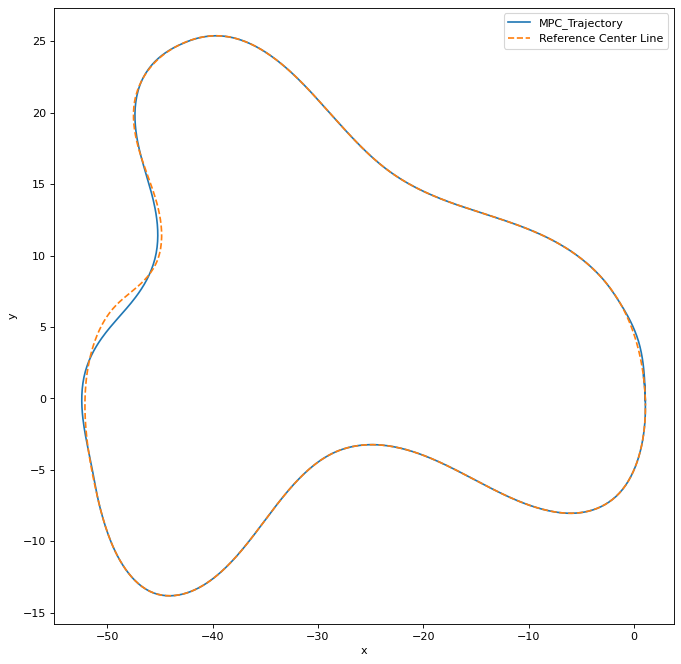

In [13]:
plt.figure(figsize=(10, 10), dpi=80)
raceline_x, raceline_y, raceline_theta = genWaypoints(raceTrack)
M = len(raceline_x)+10
t_array_ = range(M+1)
plt.plot(xOpt[0,:M], xOpt[1,:M])
plt.plot(raceline_x, raceline_y, linestyle='dashed')
plt.legend(['MPC_Trajectory', 'Reference Center Line'])
plt.xlabel('x')
plt.ylabel('y')
# plt.savefig('UniBikeModel_map3_N_30.png')
plt.show()